In [1]:
import time
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import emoji
import Preprocessing_topicM as preproc
import nltk
import warnings
warnings.filterwarnings("ignore")

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [2]:
reviews_raw = pd.read_csv(r"../data_hyderabad/10k_reviews.csv")

In [3]:
reviews_data = reviews_raw[reviews_raw["Rating"].notna() & reviews_raw["Review"].notna()]
reviews_data.isna().sum()

Restaurant    0
Reviewer      0
Review        0
Rating        0
Metadata      0
Time          0
Pictures      0
dtype: int64

In [4]:
# split UPPERCASE WORDS
def splitting_words_process(word):
    # only upper case letters
    if word.isupper():
        return word

    # more than one upper case letter inside
    elif re.search(r'[A-Z][a-z]*[A-Z]', word):
        split_word = re.findall(r'[A-Z][a-z]*', word)
        return ' '.join(split_word)

    # <2 upper case letters
    else:
        return word

reviews_data['Review'] = reviews_data['Review'].apply(lambda x: ' '.join([splitting_words_process(word) for word in x.split()]))

In [5]:
# Function to replace 'gud', 'goo', 'gd' with the appropriate 'good'
def replace_gud_with_good(text):
    if isinstance(text, str):
        # Define the regex pattern to match 'gud', 'goo', 'gd' in various capitalizations
        pattern = re.compile(r'\b([Gg][Uu][Dd]|[Gg][Oo][Oo]|[Gg][Dd])\b')

        # Replacement function to check the case of the first letter
        def replacement(match):
            word = match.group()
            # Check if the first letter is uppercase, then return 'Good', else 'good'
            if word[0].isupper():
                return 'Good'
            else:
                return 'good'

        # Use re.sub to apply the replacement function
        return pattern.sub(replacement, text)

    return text

# Apply the function to the 'Review' column to replace the variants of 'good'
reviews_data['Review'] = reviews_data['Review'].apply(replace_gud_with_good)

In [6]:
# Function to replace 'kk', 'Oke', 'k', 'Ok' with 'ok'
def replace_to_ok(text):
    if isinstance(text, str):
        # Define the regex pattern to match the variants of 'ok'
        pattern = re.compile(r'\b(k|kk|Ok|Oke)\b', re.IGNORECASE)

        # Replacement function to return 'ok' for all matched words
        def replacement(match):
            return 'ok'

        # Use re.sub to apply the replacement function
        return pattern.sub(replacement, text)

    return text

# Apply the function to the 'Review' column to replace the variants of 'ok'
reviews_data['Review'] = reviews_data['Review'].apply(replace_to_ok)

In [7]:
# add space after ! | " | # | $ | % | & | ( | ) | * | + | , | . | : | ; followed immediately by a word
def add_space_after_punctuation(df):

    df['Review'] = df['Review'].apply(lambda text: re.sub(r'([\u0021-\u0026\u0028-\u002C\u002E\u003A-\u003F]+(?=\w))', r'\1 ', text) if isinstance(text, str) else text)
    return df

# Example usage:
reviews_data = add_space_after_punctuation(reviews_data)

In [8]:
# remove gibberish words like "ggggggggggd", "eshjdgue"
def remove_gibberish(text):
    cleaned_text = re.sub(r'\b\w{15,}\b', '', text)  # removes 15+ words
    cleaned_text = re.sub(r'\b\w*(\w)\1{2,}\w*\b', '', cleaned_text)  # removes words that contain 3+ repeating letters

    return cleaned_text

reviews_data['Review'] = reviews_data['Review'].apply(remove_gibberish)

In [9]:
def remove_space_before_punctuation(text):
    if isinstance(text, str):
        # Define the regex pattern to match spaces before punctuation
        pattern = re.compile(r'\s+([?.!,;:])')

        # Use re.sub to remove spaces before punctuation
        return pattern.sub(r'\1', text)

    return text

# Apply the function to the 'Review' column to remove spaces before punctuation
reviews_data['Review'] = reviews_data['Review'].apply(remove_space_before_punctuation)

In [12]:
reviews_data["Review_preproc"] = reviews_data['Review'].apply(lambda x: preproc.main_pipeline(
    x,
    print_output=False,
    no_stopwords=True,
    custom_stopwords=[],
    convert_diacritics=True,
    no_punctuation=True,
    remove_contractions = True,
    lowercase=False,
    lemmatized=True,
    stemmed=False,
    tokenized_output=False
))

In [13]:
def remove_space_before_punctuation(text):
    if isinstance(text, str):
        # Define the regex pattern to match spaces before punctuation
        pattern = re.compile(r'\s+([?.!,;:])')

        # Use re.sub to remove spaces before punctuation
        return pattern.sub(r'\1', text)

    return text

# Apply the function to the 'Review' column to remove spaces before punctuation
reviews_preproc = reviews_data["Review_preproc"] .apply(remove_space_before_punctuation)

### LSA

In [14]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from gensim.models import LsiModel, LdaModel
from gensim.models.coherencemodel import CoherenceModel
from gensim import corpora

In [15]:
bow = CountVectorizer(ngram_range=(1,1), stop_words= "english", token_pattern=r"(?u)\b\w+\b")
bow_matrix = bow.fit_transform(reviews_data["Review_preproc"] )

In [16]:
lsa = TruncatedSVD(n_components=50)  # The number of components can also be optimized
lsa_result = lsa.fit_transform(bow_matrix)

In [17]:
bow_words = bow.get_feature_names_out()

In [18]:
tokenized_reviews = [nltk.word_tokenize(review) for review in reviews_data["Review_preproc"] ]
reviews_dict = corpora.Dictionary(tokenized_reviews)
reviews_corpus = [reviews_dict.doc2bow(doc) for doc in tokenized_reviews]

In [19]:
lda_gensim = LdaModel(reviews_corpus, id2word=reviews_dict, num_topics=20,iterations=50)

In [20]:
lda_gensim.show_topics(20)

[(0,
  '0.028*"service" + 0.028*"food" + 0.026*"good" + 0.025*"time" + 0.019*"buffet" + 0.017*"lunch" + 0.016*"place" + 0.014*"go" + 0.012*"customer" + 0.012*"experience"'),
 (1,
  '0.059*"order" + 0.022*"quantity" + 0.021*"food" + 0.021*"deliver" + 0.019*"taste" + 0.018*"bad" + 0.018*"less" + 0.018*"delivery" + 0.017*"time" + 0.016*"good"'),
 (2,
  '0.041*"food" + 0.018*"make" + 0.016*"order" + 0.016*"place" + 0.012*"like" + 0.010*"u" + 0.010*"visit" + 0.010*"good" + 0.008*"quality" + 0.008*"experience"'),
 (3,
  '0.022*"place" + 0.018*"try" + 0.012*"taste" + 0.012*"cheese" + 0.011*"food" + 0.011*"like" + 0.011*"time" + 0.009*"sauce" + 0.009*"visit" + 0.008*"would"'),
 (4,
  '0.022*"ask" + 0.020*"place" + 0.019*"order" + 0.014*"say" + 0.014*"waiter" + 0.013*"take" + 0.013*"manager" + 0.012*"hour" + 0.012*"one" + 0.010*"go"'),
 (5,
  '0.041*"chicken" + 0.029*"order" + 0.022*"fry" + 0.021*"soup" + 0.016*"rice" + 0.013*"restaurant" + 0.013*"taste" + 0.011*"try" + 0.010*"place" + 0.010*"p

In [21]:
# Save the top 3 words for each topic
top_words_per_topic = []
for topic_id, topic in lda_gensim.show_topics(formatted=False, num_words=3, num_topics=20):
    top_words = [word for word, _ in topic]
    top_words_per_topic.append((topic_id, top_words))

# Display the top words for each topic along with the topic number
top_words_per_topic

[(0, ['service', 'food', 'good']),
 (1, ['order', 'quantity', 'food']),
 (2, ['food', 'make', 'order']),
 (3, ['place', 'try', 'taste']),
 (4, ['ask', 'place', 'order']),
 (5, ['chicken', 'order', 'fry']),
 (6, ['place', 'good', 'food']),
 (7, ['order', 'taste', 'Biryani']),
 (8, ['good', 'place', 'food']),
 (9, ['car', 'yum', 'place']),
 (10, ['biryani', 'burger', 'chicken']),
 (11, ['bad', 'thank', 'food']),
 (12, ['place', 'best', 'one']),
 (13, ['buffet', 'good', 'starter']),
 (14, ['chocolate', 'cake', 'cream']),
 (15, ['delivery', 'food', 'awesome']),
 (16, ['good', 'chicken', 'food']),
 (17, ['serve', 'good', 'cake']),
 (18, ['food', 'service', 'good']),
 (19, ['coffee', 'taste', 'good'])]

In [22]:
lda_gensim.get_document_topics(reviews_corpus[0])

[(8, 0.8255308), (10, 0.06361331), (18, 0.07609333)]

In [23]:
# Function to get top 3 topics and their probabilities for each review
def get_top_topics_for_reviews(reviews_corpus, lda_model, n=3):
    top_topics = []
    for doc in reviews_corpus:
        topics = lda_model.get_document_topics(doc, minimum_probability=0)
        sorted_topics = sorted(topics, key=lambda x: x[1], reverse=True)[:n]
        top_topics.append(sorted_topics)
    return top_topics

# Get top 3 topics for each review
top_topics_per_review = get_top_topics_for_reviews(reviews_corpus, lda_gensim, n=3)

# Separate topics and probabilities into different columns
reviews_data['Top_Topics'] = [ [top_words_per_topic[topic][1] for topic, _ in topics] for topics in top_topics_per_review ]
reviews_data['Topics_Probabilities'] = [ [prob for _, prob in topics] for topics in top_topics_per_review ]

# Display the dataframe with the new columns
reviews_with_topics_lda = reviews_data[["Review","Top_Topics","Topics_Probabilities"]]


In [24]:
reviews_with_topics_lda

Review  \
0     The ambience was good, food was quite good. ha...   
1     Ambience is too good for a pleasant evening. S...   
2     A must try.. great food great ambience. Thnx f...   
3     Soumen das and Arun was a great guy. Only beca...   
4     Food is good. we ordered Kodi drumsticks and b...   
...                                                 ...   
9995  Madhumathi Mahajan Well to start with nice cou...   
9996  This place has never disappointed us.. The foo...   
9997  Bad rating is mainly because of " Chicken Bone...   
9998  I personally love and prefer Chinese Food. Had...   
9999  Checked in here to try some delicious chinese ...   

                                             Top_Topics  \
0     [[good, place, food], [food, service, good], [...   
1     [[food, service, good], [good, place, food], [...   
2     [[good, place, food], [good, chicken, food], [...   
3     [[good, place, food], [place, good, food], [se...   
4     [[good, place, food], [biryani, burger, chicke...   
...                                                 ...   
9995  [[good, chicken, food], [serve, good, cake], [...   
9996  [[place, try, taste], [good, chicken, food], [...   
9997  [[good, chicken, food], [buffet, good, starter...   
9998  [[food, service, good], [place, good, food], [...   
9999  [[chicken, order, fry], [good, chicken, food],...   

                         Topics_Probabilities  
0       [0.82547927, 0.076157875, 0.06360025]  
1        [0.5166532, 0.42668328, 0.003147976]  
2        [0.51991653, 0.29778418, 0.13640842]  
3     [0.9344475, 0.0034501296, 0.0034501294]  
4        [0.47866562, 0.23631142, 0.12152885]  
...                                       ...  
9995      [0.4162109, 0.19534369, 0.14091246]  
9996    [0.5178276, 0.45401394, 0.0015643617]  
9997     [0.5836932, 0.14682266, 0.063196465]  
9998     [0.31919304, 0.23414207, 0.22497894]  
9999      [0.41949415, 0.3418545, 0.14471538]  

[9955 rows x 3 columns]

In [25]:
lda_gensim.log_perplexity(reviews_corpus) 

-9.198537077985621

In [26]:
cm = CoherenceModel(model=lda_gensim, texts=tokenized_reviews , coherence='c_v')
cm.get_coherence()  

0.4104479535143756

In [52]:
cm_topic = cm.get_coherence_per_topic()
topics = [topic[0] for topic in lda_gensim.show_topics(num_topics=20)]
topics_coherence = pd.DataFrame({'Topic': topics, 'Coherence': cm_topic})

topics_coherence

Topic  Coherence
0       0   0.459751
1       1   0.427324
2       2   0.424485
3       3   0.404853
4       4   0.606886
5       5   0.518005
6       6   0.397797
7       7   0.351848
8       8   0.385019
9       9   0.333085
10     10   0.340449
11     11   0.333252
12     12   0.329657
13     13   0.504637
14     14   0.471075
15     15   0.272649
16     16   0.515072
17     17   0.407244
18     18   0.414536
19     19   0.311335

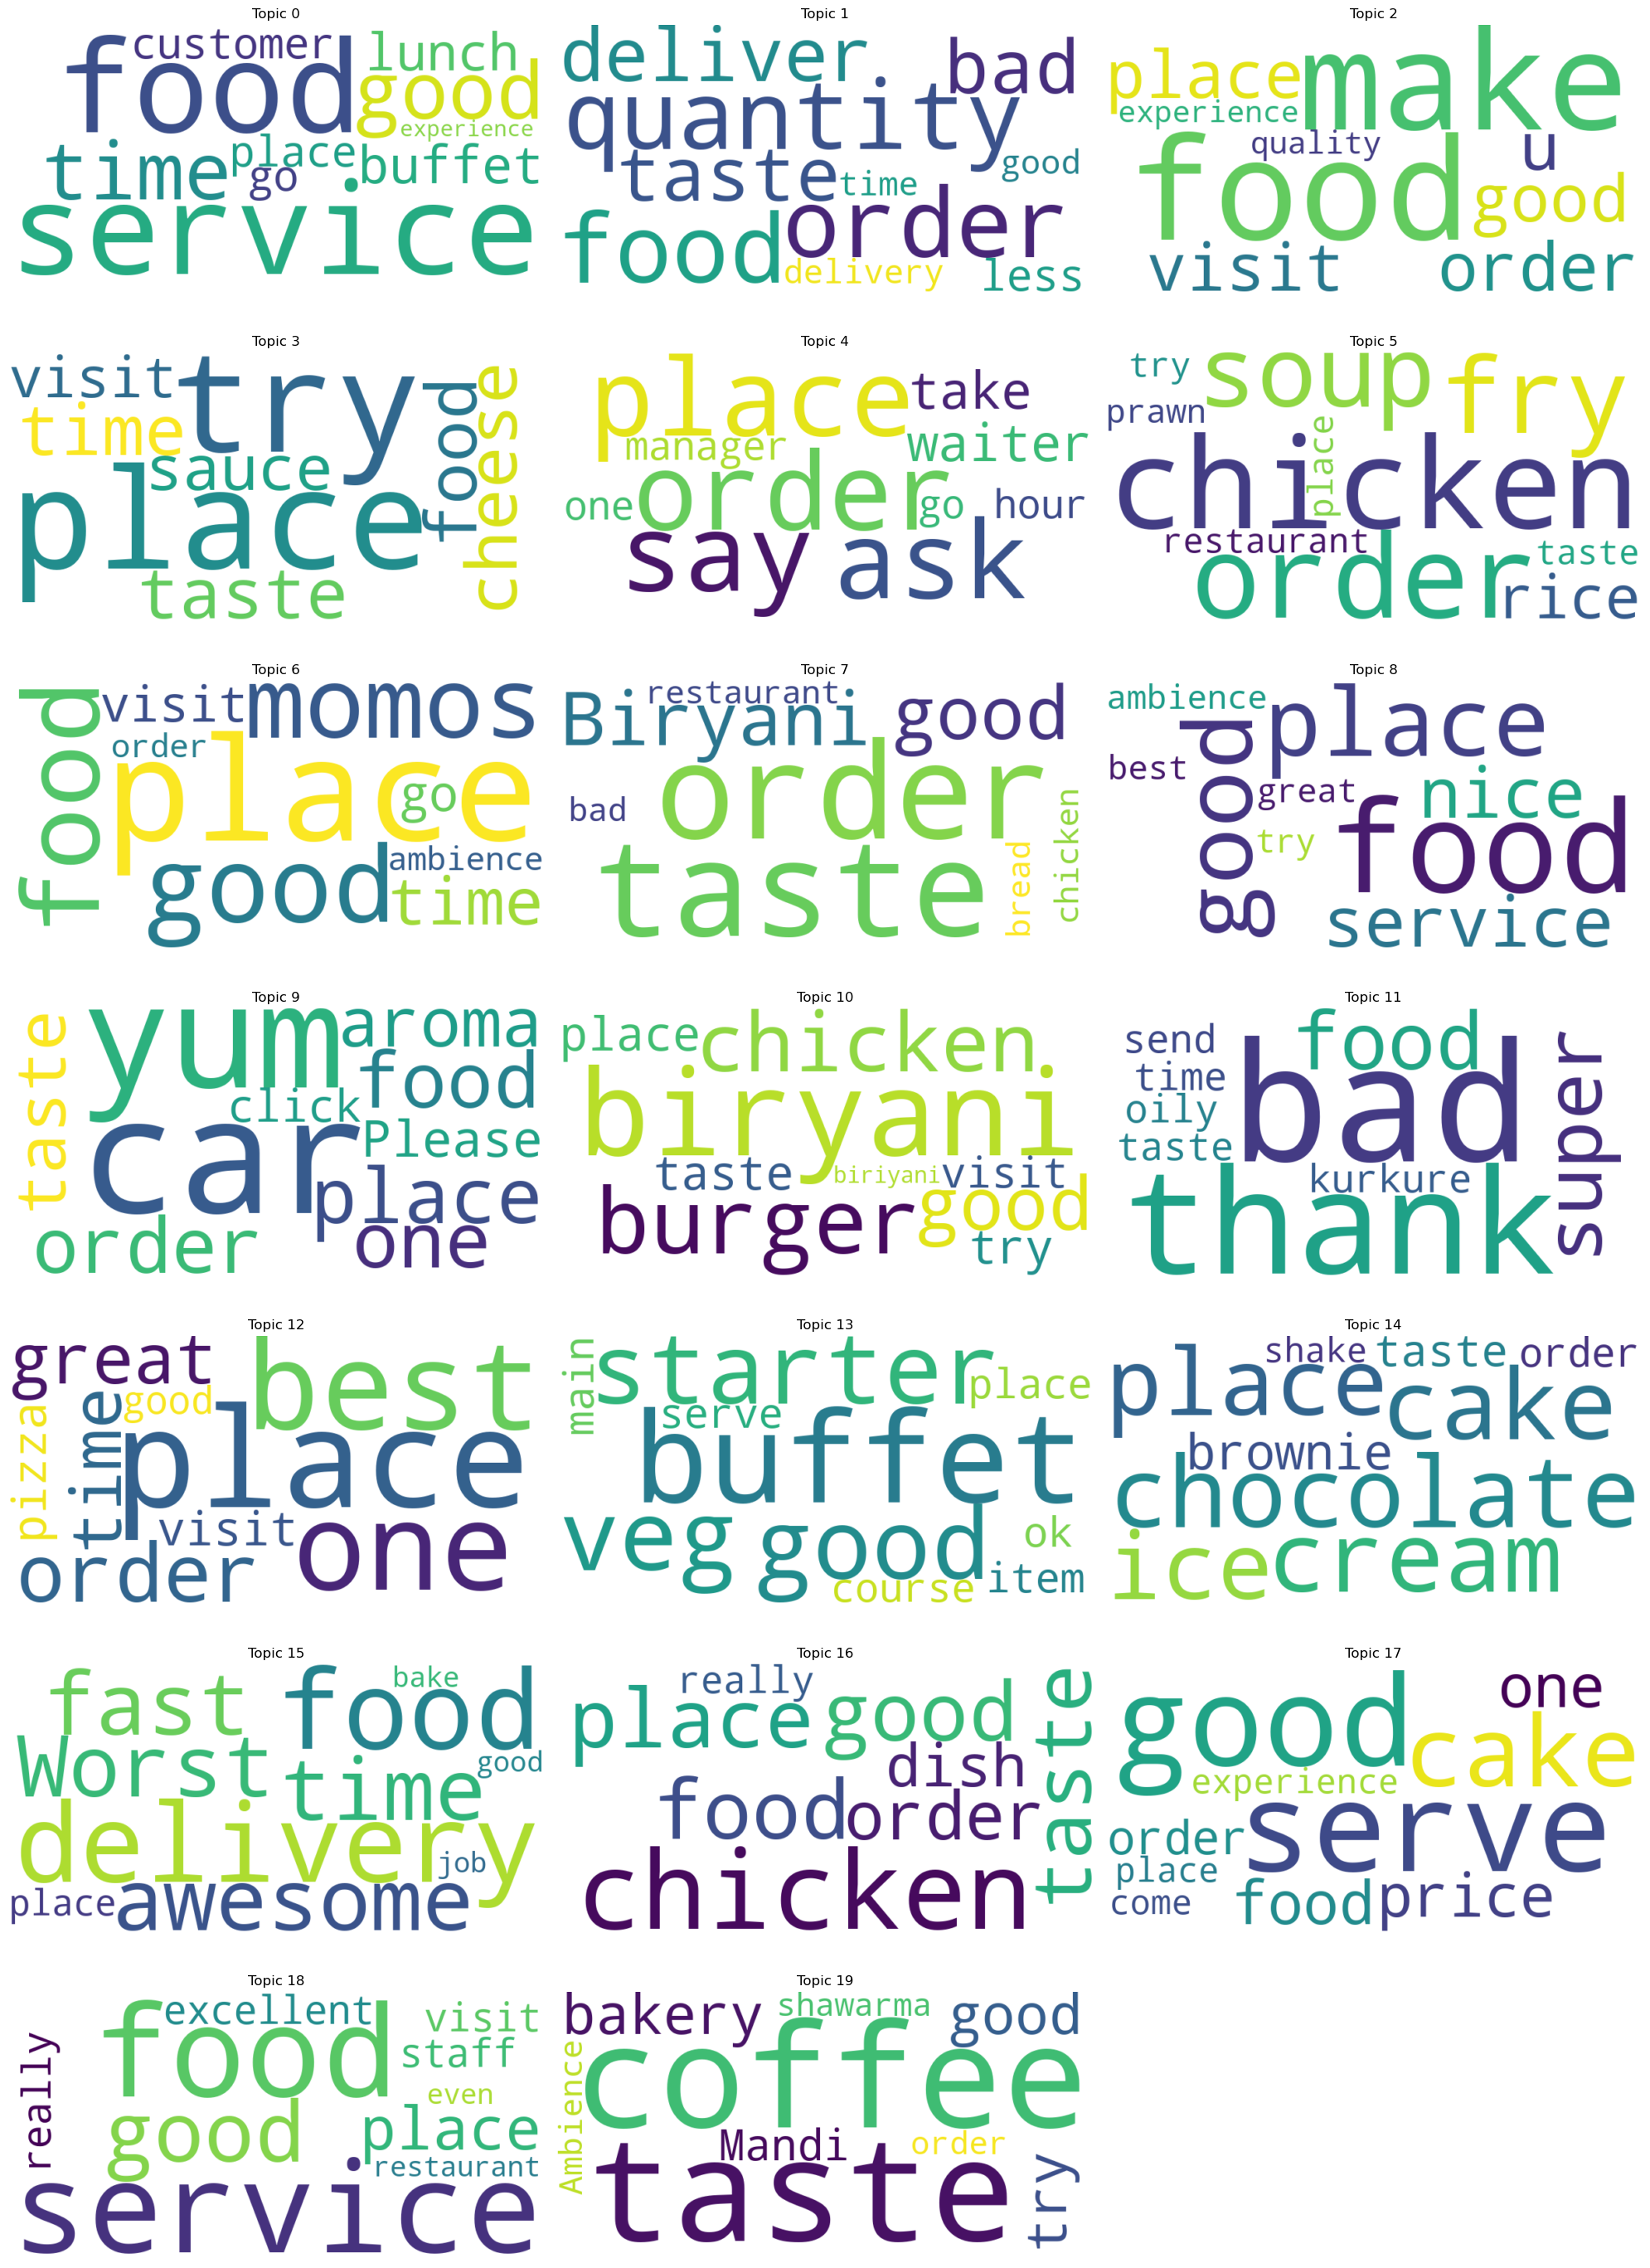

In [ ]:
#this code below was generatd by claude copilot

from wordcloud import WordCloud
import matplotlib.pyplot as plt

def create_topic_wordcloud(lda_model, num_topics=20, num_words=10):
    # Create a figure with subplots
    n_cols = 3  # You can adjust number of columns
    n_rows = (num_topics + n_cols - 1) // n_cols
    
    fig = plt.figure(figsize=(20, 4*n_rows))
    
    for topic_id in range(num_topics):
        # Create subplot for each topic
        ax = fig.add_subplot(n_rows, n_cols, topic_id + 1)
        
        # Get words for current topic
        topic_words = lda_model.show_topic(topic_id, topn=num_words)
        words = ' '.join([word for word, _ in topic_words])
        
        # Generate word cloud
        wordcloud = WordCloud(
            width=800, 
            height=400,
            background_color='white',
            max_words=num_words
        ).generate(words)
        
        # Display word cloud
        ax.imshow(wordcloud, interpolation='bilinear')
        ax.axis('off')
        ax.set_title(f'Topic {topic_id}')
    
    plt.tight_layout()
    plt.show()

# Create word clouds for each topic
create_topic_wordcloud(lda_gensim, num_topics=20, num_words=10)


In [ ]:
custom_merged_model.get_topic_info()